# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    # %run "S2-decode-behav-corr.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


---


In [4]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [6]:
@utility.report
def plot_monkey_decode_corr(ax, allDFs_MCx):
    try:
        os.chdir(params.repoPath / 'monkey')
        %run "_monkey-corr.ipynb"
    finally:
        os.chdir(NBPath)
        
    across_corrs_monkeys = trim_across_monkey_corr(allDFs_MCx)

    pairFileList_monkeys = []
    for I, df1 in enumerate(allDFs_MCx):
        for J, df2 in enumerate(allDFs_MCx):
            if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
            pairFileList_monkeys.append((I,J))
            
    side1df = [allDFs_MCx[i] for i,_ in pairFileList_monkeys]
    side2df = [allDFs_MCx[j] for _,j in pairFileList_monkeys]
    AllData1_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2_monkey = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

    CC_corr_monkey=[]
    for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey,AllData2_monkey)):
        data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
        k,l = pairFileList_monkeys[i]
        behav = np.array(across_corrs_monkeys[allDFs_MCx[k].session[0]][allDFs_MCx[l].session[0]])
        behav = behav[behav>params.Behav_corr_TH]
        CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
    CC_corr_monkey = np.array(CC_corr_monkey)
    
    #plotting
    ax.scatter(CC_corr_monkey[:,1],CC_corr_monkey[:,0], color=params.colors.MonkeyPts, label='Monkeys', zorder=0)
    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    ax.set_ylim([.53,.85])
    ax.spines['left'].set_bounds([.55,.85])
    ax.set_xlim([.69,.95])
    ax.spines['bottom'].set_bounds([.7,.95])
    ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    
@utility.report
def plot_mouse_decode_corr(ax, AllDFs):
    try:
        os.chdir(params.repoPath / 'mouse')
        %run "_mouse-corr.ipynb"
    finally:
        os.chdir(NBPath)
        
    across_corrs_mice = trim_across_mouse_corr (AllDFs)
    
    
    pairIndex_across = []
    for i, df1 in enumerate(AllDFs):
        animal1 = df1.mouse[0]
        pairIndex_across.append((i,[]))
        for j, df2 in enumerate(AllDFs):
            if j<i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

    reg_scores_across = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch, area=defs.areas[0], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))

        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))

        # train the decoder
        *_,U,V = dt.canoncorr(X1[goodIndex,:], X2[goodIndex,:], fullReturn=True)
        Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
        reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        reg_z.fit(U, Y_train_z)
        # test the decoder
        Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
        reg_scores_across.append((id1,testId,(x_score,y_score,z_score)))
    pop_score_across = []
    for _,_,scores in reg_scores_across:
        pop_score_across.append(np.mean(scores))
    pop_score_across = np.array(pop_score_across)

    
    corr_mice=[]
    for i, (id1, testId) in enumerate(pairIndex_across):
        df1, df2 = AllDFs[id1] , AllDFs[testId]
        behav = np.array(across_corrs_mice[df1.file[0]][df2.file[0]])
        behav = behav[behav>params.Behav_corr_TH]
        decode = pop_score_across[i]
        corr_mice.append((decode , np.mean(behav)))
    corr_mice = np.array(corr_mice)

    #plotting
    ax.scatter(corr_mice[:,1],corr_mice[:,0],color=params.colors.MousePts, label='Mice', zorder=1)

In [7]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()
    
    # allDFs_MCx, _ = get_full_monkey_data()
    allDFs_M1, _ = get_full_mouse_data()

    
    plot_mouse_decode_corr(ax, allDFs_M1)
    # plot_monkey_cca_corr(ax, allDFs_MCx[10:15])
    
    
    plt.show()

/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing 

Executed: `get_full_mouse_data` in 0.8s
Executed: `plot_mouse_decode_corr` in 7.5s


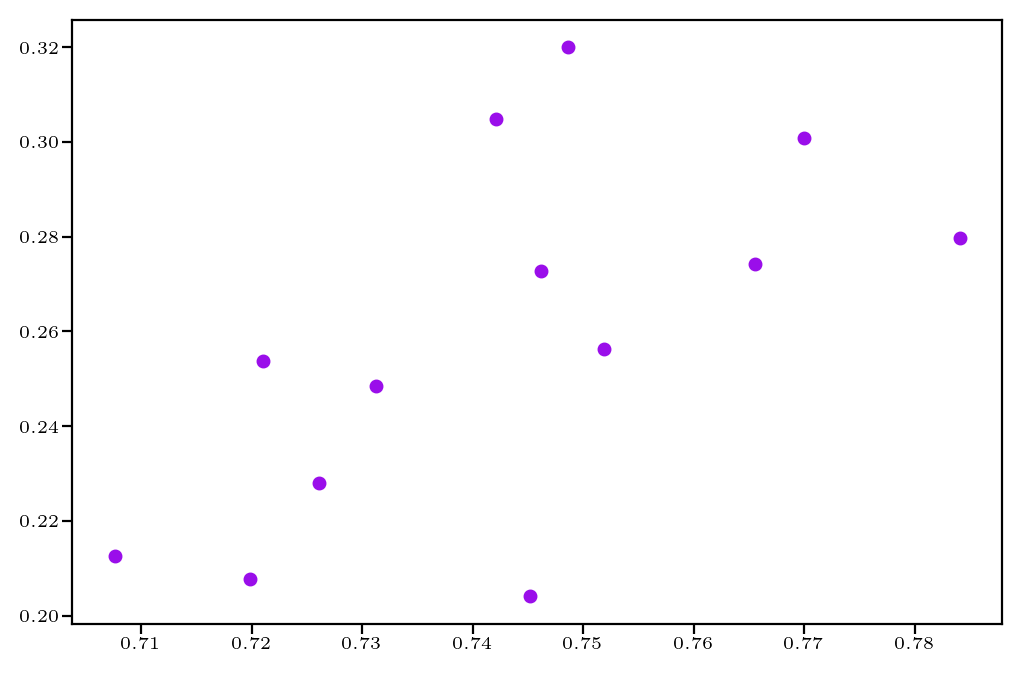

In [8]:
fig

# Behavioural Correlations Functions

In [2]:
try:
    os.chdir(params.repoPath / 'monkey')
    %run "_monkey-corr.ipynb"
    
    defs = params.mouse_defs
    os.chdir(params.repoPath / 'mouse')
    %run "_mouse-corr.ipynb"
finally:
    os.chdir(params.repoPath / 'common')


# Read data and Load decoding data

In [3]:
try:
    os.chdir(params.repoPath / 'monkey')
    %run "MCx-decoding.ipynb"
    monkey_df, monkey_index, monkey_decode = allDFs, pairIndex_across, pop_score_across
    del allDFs, pairIndex_across, pop_score_across
    
    os.chdir(params.repoPath / 'mouse')
    %run "mouse-M1-decoding.ipynb"
    mouse_df, mouse_index, mouse_decode = AllDFs, pairIndex_across, pop_score_across
    del AllDFs, pairIndex_across, pop_score_across
finally:
    os.chdir(params.repoPath / 'common')


# Calculate the correlations

In [4]:
if "__file__" not in dir():
    across_corrs_mice = trim_across_mouse_corr (mouse_df)
    
    defs = params.monkey_defs
    
    across_corrs_monkeys = trim_across_monkey_corr (monkey_df)

/tmp/ipykernel_13453/1028716824.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1__, epoch_fun=defs.exec_epoch)
/tmp/ipykernel_13453/1028716824.py:44: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch)


# Assemble the data structure

In [5]:
corr_mice=[]
for i, (id1, testId) in enumerate(mouse_index):
    df1, df2 = mouse_df[id1] , mouse_df[testId]
    behav = np.array(across_corrs_mice[df1.file[0]][df2.file[0]])
    behav = behav[behav>params.Behav_corr_TH]
    decode = mouse_decode[i]
    corr_mice.append((decode , np.mean(behav)))
corr_mice = np.array(corr_mice)


corr_monkey=[]
for i, (id1, testId) in enumerate(monkey_index):
    df1, df2 = monkey_df[id1] , monkey_df[testId]
    behav = np.array(across_corrs_monkeys[df1.session[0]][df2.session[0]])
    behav = behav[behav>params.Behav_corr_TH]
    decode = monkey_decode[i]
    corr_monkey.append((decode , np.mean(behav)))
corr_monkey = np.array(corr_monkey)

# plot

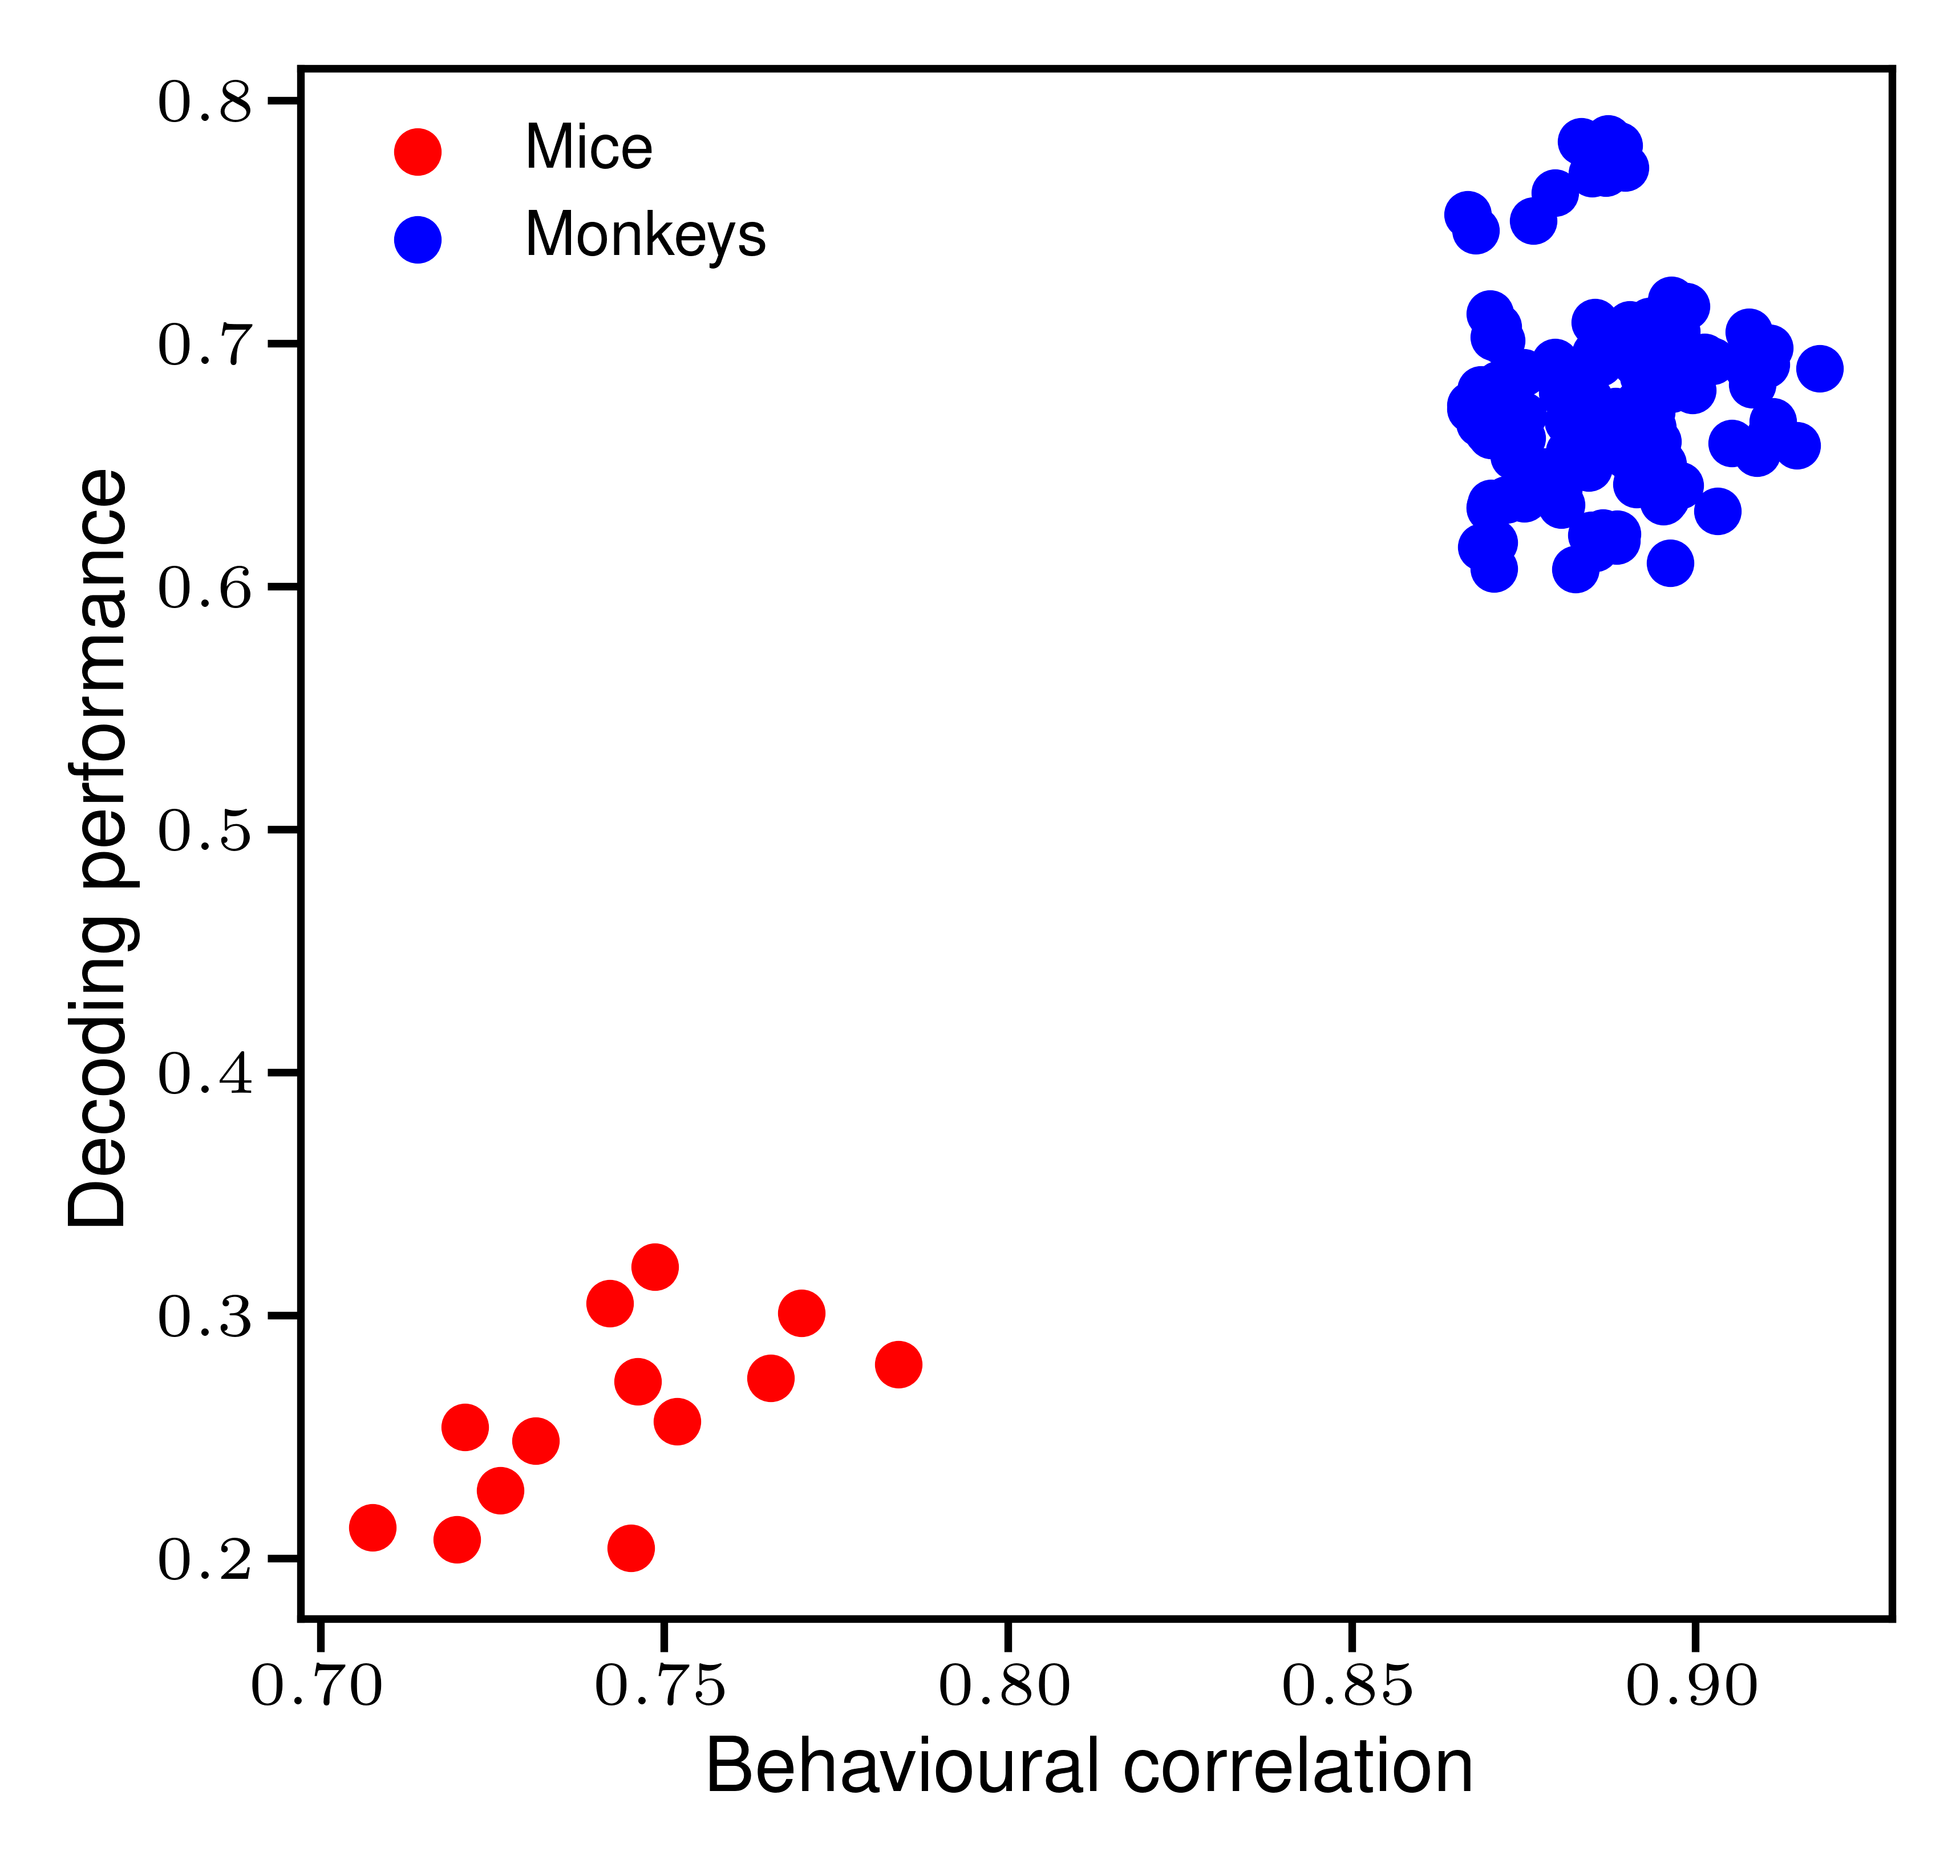

In [6]:
if "__file__" not in dir():     
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    
    ax.scatter(corr_mice[:,1],corr_mice[:,0],color='r', label='Mice', zorder=1)
    ax.scatter(corr_monkey[:,1],corr_monkey[:,0], color='b', label='Monkeys', zorder=0)

    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Decoding performance')
    ax.legend()
    
#     ax.set_title(f'min. behav. corr.: {Behav_corr_TH:0.2f}')
    
    
    fig.savefig(params.figPath / 'traj-decode-corr.pdf', format='pdf', bbox_inches='tight')